In [379]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [380]:
# 기본 세팅
name1 = "KO"
name2 = "TSLA"
cut_left = -0.1
cut_right = 0.1
num_bins = 32
num_dataset = 2000

## 금융 데이터를 yfinance로부터 받아오기

In [381]:
import yfinance as yf
import datetime

def get_stocks_datas(ticker_names: list[str], start_date, end_date):
    # WARN: returns는 prices보다 길이가 1 작다.
    prices = {}
    returns = {}
    for name in ticker_names:
        data = yf.Ticker(name)
        data = data.history(start=start_date, end=end_date, interval="1d")
        prices[name] = data['Close']
        returns[name] = data['Close'].pct_change()[1:]
    return prices, returns

start_date = datetime.datetime(2011, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
stock_prices, stock_returns = get_stocks_datas([name1, name2], start_date, end_date)


KeyboardInterrupt: 

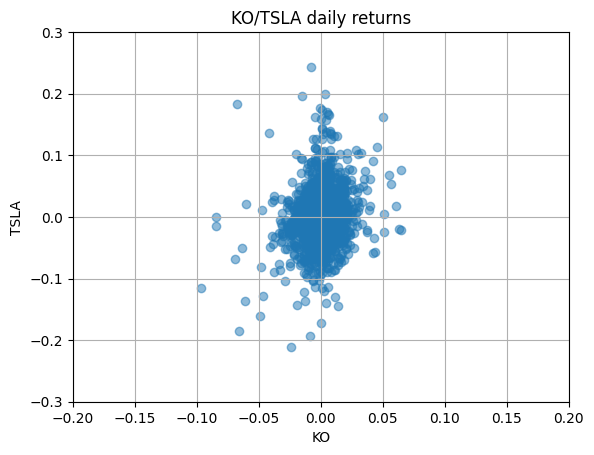

In [ ]:
# 산점도 그리기
plt.scatter(stock_returns[name1].values, stock_returns[name2].values, alpha=0.5)
plt.title(f'{name1}/{name2} daily returns')
plt.xlabel(name1)
plt.ylabel(name2)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.3, 0.3)
plt.grid(True)
plt.show()

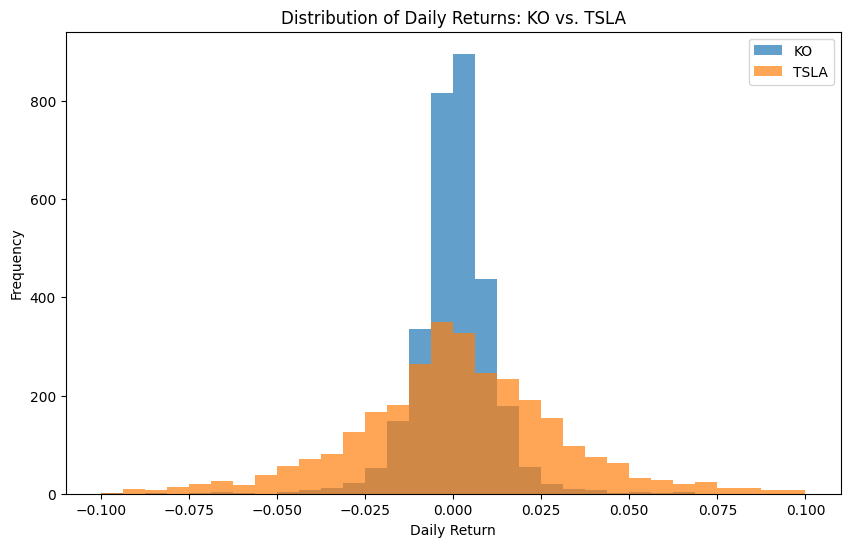

Mean of KO: 0.0004
Mean of TSLA: 0.0020


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bin_edges = np.linspace(cut_left, cut_right, num_bins+1)

plt.figure(figsize=(10, 6))

plt.hist(stock_returns[name1].values, bins=bin_edges, alpha=0.7, label=name1)
plt.hist(stock_returns[name2].values, bins=bin_edges, alpha=0.7, label=name2)

plt.title(f'Distribution of Daily Returns: {name1} vs. {name2}')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Mean of {name1}: {stock_returns[name1].mean():.4f}")
print(f"Mean of {name2}: {stock_returns[name2].mean():.4f}")


## risk-return space에 그려보자
앞으로 우리가 뽑을 최종 결과물이다

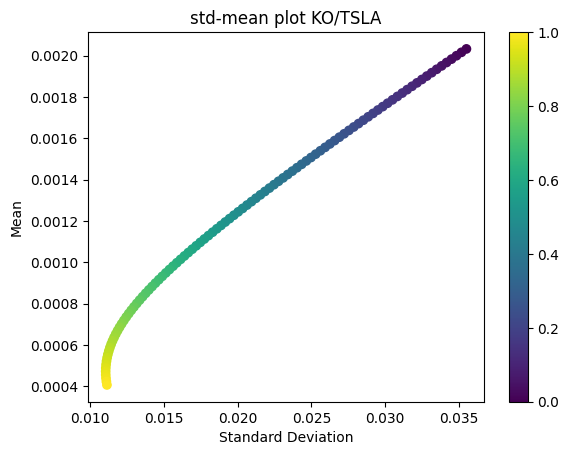

In [ ]:
x = []
y = []
c = []
for k in np.linspace(0, 1, 100):
    merged_returns = k * stock_returns[name1].values + (1 - k) * stock_returns[name2].values
    x.append(merged_returns.std())
    y.append(merged_returns.mean())
    c.append(k)

plt.scatter(x, y, c=c, cmap='viridis')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')
plt.title(f'std-mean plot {name1}/{name2}')
plt.colorbar()
plt.show()

## Dataset 생성

linespace로 균일하게 내분해서 절반, uniform으로 절반 생성한다

In [ ]:
dataset = []
def add_dataset(alpha):
    # 첫번째 주식을 alpha, 두번째 주식을 1-alpha만큼.
    bins = np.linspace(-0.1, 0.1, num_bins + 1)
    returns = alpha * stock_returns[name1].values + (1 - alpha) * stock_returns[name2].values
    hist, _ = np.histogram(returns, bins=bins)
    dataset.append(hist/sum(hist))

for t in np.linspace(0, 1, num_dataset//2): # 절반은 직접 내분
    add_dataset(t)
for t in np.random.uniform(0, 1, num_dataset//2): # 절반은 랜덤
    add_dataset(t)

dataset = np.array(dataset)
print(dataset.shape)

(2000, 32)


In [ ]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
noise_qubits = 5
code_qubits = 1
output_qubits = 5 # 실제로 출력 상태를 만드는데 쓰이는 개수
n_qubits = noise_qubits
assert(output_qubits <= n_qubits)

n_layers = 40
BATCH_SIZE = 16

print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))
dev = qml.device("default.qubit", wires=n_qubits) # 제너레이터 돌려서 값 뽑아내는데 쓰임. 이중 몇개 골라서 판별자도 학습함.

n_qubits = 5 n_layers = 40


In [ ]:
coeff = 0.10

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i] * np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    generator_init(generator_input)
    for param in params:
        generator_layer(param)
    return qml.probs(wires=range(output_qubits))


def generator_forward(params, generator_input):
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input] # (BATCH_SIZE, 2**output_qubits) 차원
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, 2**output_qubits) 차원
    return generator_output


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    code_input = generator_input[:, -code_qubits:]

    generator_output = generator_forward(params, generator_input)
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi


    return generator_output, gan_loss

In [387]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=num_bins):
        super().__init__()
        self.hidden_size = 100
        channel_size = 16
        self.input_dim = input_dim
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=channel_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            #nn.Dropout(p=0.7),
            nn.Flatten(),
            nn.Linear(num_bins * channel_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size), 
            nn.LeakyReLU(),
            #nn.Dropout(p=0.7),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size), 
            nn.LeakyReLU(),
            #nn.Dropout(p=0.7),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())


    def forward(self, x):
        x = x.view(-1, 1, self.input_dim)
        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 150
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(2**output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2


disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss

In [388]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)
discriminator = LinearDiscriminator()
mine = LinearMine()

G_lr = 1e-3
D_lr = 1e-4
M_lr = 3e-4
use_mine = True
use_qmine = False
G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_opt, step_size=30, gamma=0.7)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.8)

parameter shape:  torch.Size([40, 5, 3])


In [389]:
import os
############# 가장 최신 버전 폴더로 저장한다 #############
file_num = 1
title = f'mine={use_mine}_try={file_num}'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')
else:
    while os.path.exists(f'result/{title}'):
        file_num += 1
        title = f'mine={use_mine}_try={file_num}'
        if not os.path.exists(f'result/{title}'):
            os.makedirs(f'result/{title}')
            break
###################################################

with open(f'result/{title}/param.txt', 'w') as f:
    f.write('사용주식1 = {} 사용주식2 = {}\n'.format(name1,name2))
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('G_scheduler: step={}, gamma={}\n'.format(G_scheduler.step_size, G_scheduler.gamma))
    f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('noise_qubits = {}\n'.format(noise_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [390]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

def visualize_output(gen_outputs, gen_codes, means, stds, title, rep, recorder):
    warnings.simplefilter("ignore")


    random_indices = np.random.choice(gen_outputs.shape[0], size=9, replace=False)
    selected_samples = [gen_outputs[i] for i in random_indices]
    selected_codes = [gen_codes[i][0] for i in random_indices]

    sorted_indices = np.argsort(selected_codes)
    sorted_selected_codes = [selected_codes[i] for i in sorted_indices]
    sorted_selected_samples = [selected_samples[i] for i in sorted_indices]

    plt.figure(figsize=(12, 8))

    for i, sample in enumerate(sorted_selected_samples):
        plt.subplot(3, 3, i + 1)
        plt.bar(np.linspace(-0.1, 0.1, num_bins), sample, width=0.2*(num_bins+1)/num_bins**2)
        plt.title(f'{sorted_selected_codes[i]:.3f}')
        plt.ylim(0, 0.3)
        plt.xlabel('Return')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"Epoch {rep}, random imgs")
    plt.savefig(f'result/{title}/samples_{rep}.png')
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} recorder'.format(rep))
    plt.plot(recorder['mi'], label='mi', marker='o')
    plt.plot(recorder['d_loss'], label='d_loss', marker='o')
    plt.plot(recorder['g_loss'], label='g_loss', marker='o')

    for i in range(code_qubits):
        plt.plot(recorder[f'c{i}-mean'], label=f'c{i}-mean', marker='o')
        plt.plot(recorder[f'c{i}-std'], label=f'c{i}-std', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('values')
    plt.ylim(-1, 1)
    plt.title(f'record (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/record_{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()

    plt.figure(figsize=(6 + 4 * code_qubits, 4))  # 전체 그림의 크기 지정
    for i in range(code_qubits):
        plt.subplot(1, code_qubits, i+1)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(stds, means, s=15, c=gen_codes[:, i], cmap='RdYlBu', alpha=0.6)
        plt.colorbar()  # 색상 막대 추가
        plt.grid()
    
    plt.savefig(f'result/{title}/mean_std_{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()

def calculate_mean_std(probs):
    d = (cut_right - cut_left) / num_bins * (num_bins // 2 - 0.5) # 히스토그램 오른쪽 끝 중심값
    vals = np.linspace(-d, d, num_bins)
    mean = np.sum(probs * vals) # 평균 계산
    std = np.sqrt(np.sum(probs * (vals - mean)**2)) # 표준편차 계산
    return mean, std

def calculate_corr(gen_outputs, code_inputs):
    # gen_outputs: (B, bin_num), code_inputs: (B, code_qubits)
    means = []
    stds = []
    for i in range(len(gen_outputs)):
        mean, std = calculate_mean_std(gen_outputs[i])
        means.append(mean)
        stds.append(std)
    mean_corrs = []
    std_corrs = []
    for i in range(code_qubits):
        mean_corrs.append(np.corrcoef(means, code_inputs[:,i])[0,1])
        std_corrs.append(np.corrcoef(stds, code_inputs[:,i])[0,1])
    
    return mean_corrs, std_corrs, means, stds

100%|██████████| 31/31 [01:29<00:00,  2.90s/it, G_loss=-.775, D_loss=0.697, MI=-.000894]


epoch: 1, D_loss: 0.6970200134861854, G_loss: -0.7745318701190333, MI = -0.0008943388538975869


100%|██████████| 31/31 [01:28<00:00,  2.86s/it, G_loss=-.747, D_loss=0.685, MI=0.000367]


epoch: 2, D_loss: 0.6845997552717885, G_loss: -0.7467562652403309, MI = 0.0003666118268043764


100%|██████████| 31/31 [01:25<00:00,  2.76s/it, G_loss=-.728, D_loss=0.678, MI=0.000823]


epoch: 3, D_loss: 0.6782403607522288, G_loss: -0.7283317177526413, MI = 0.0008232074399148264


100%|██████████| 31/31 [01:24<00:00,  2.73s/it, G_loss=-.713, D_loss=0.675, MI=0.00119] 


epoch: 4, D_loss: 0.6749265366984952, G_loss: -0.713280608577113, MI = 0.0011913670647528865


100%|██████████| 31/31 [01:24<00:00,  2.71s/it, G_loss=-.703, D_loss=0.669, MI=0.00256]


epoch: 5, D_loss: 0.6686876608479407, G_loss: -0.7025768872230284, MI = 0.002559732044896772


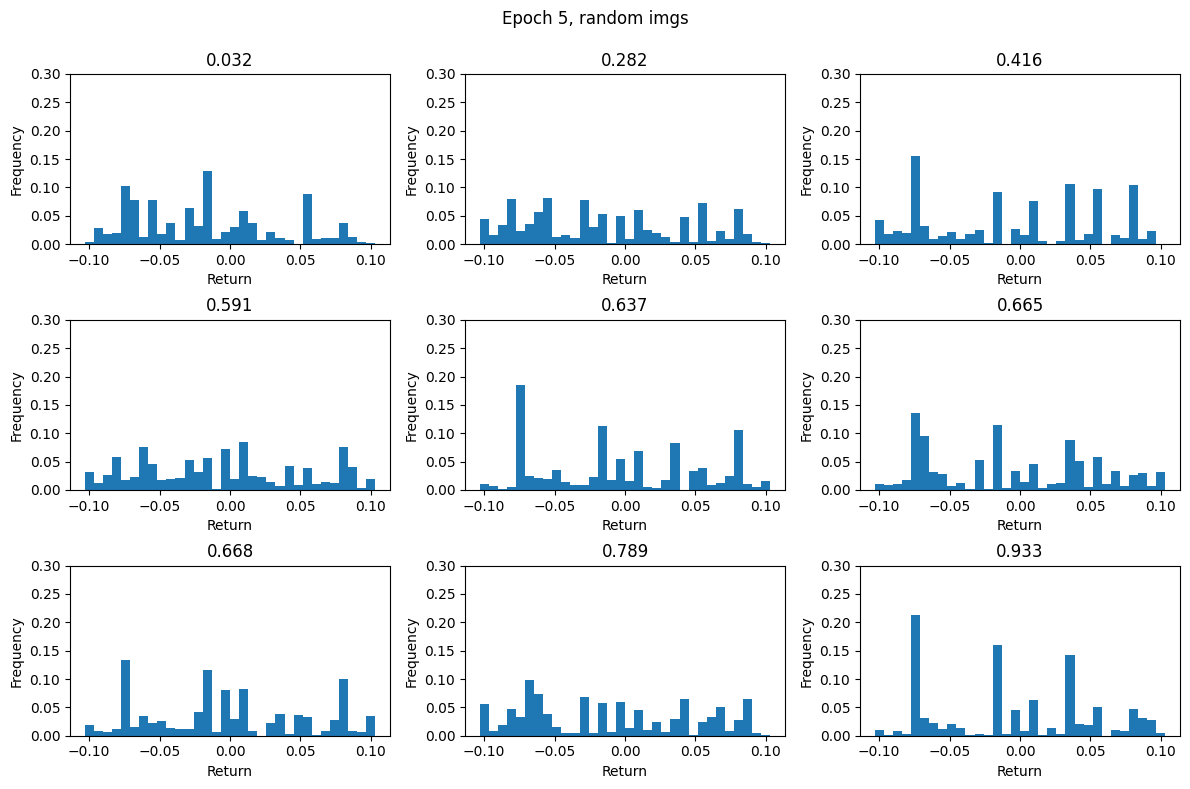

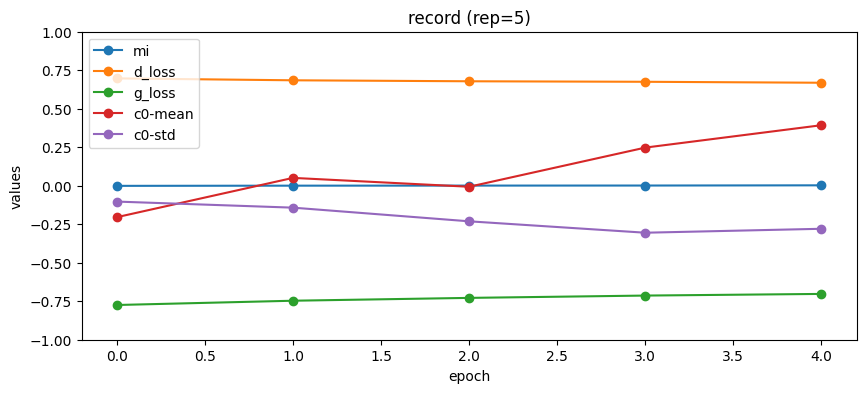

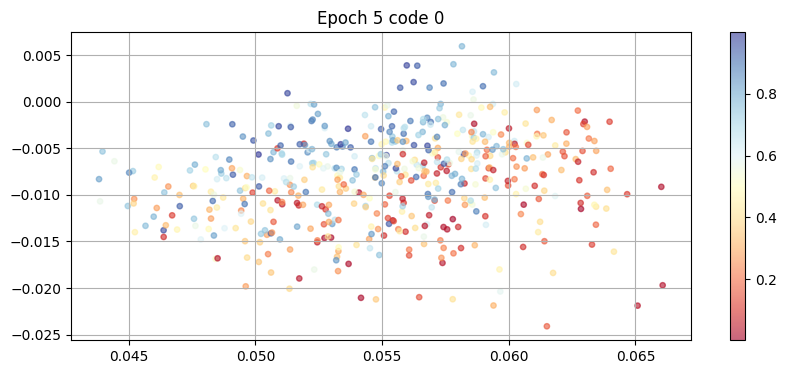

100%|██████████| 31/31 [01:24<00:00,  2.72s/it, G_loss=-.69, D_loss=0.662, MI=0.00371] 


epoch: 6, D_loss: 0.6624349797925642, G_loss: -0.6895648913998758, MI = 0.0037131376804844024


100%|██████████| 31/31 [01:24<00:00,  2.74s/it, G_loss=-.682, D_loss=0.662, MI=0.00509]


epoch: 7, D_loss: 0.6615523138353901, G_loss: -0.6815787457650707, MI = 0.005085044330166232


100%|██████████| 31/31 [01:24<00:00,  2.74s/it, G_loss=-.68, D_loss=0.661, MI=0.00732] 


epoch: 8, D_loss: 0.6611676043079745, G_loss: -0.6804632871381698, MI = 0.007324466782231484


100%|██████████| 31/31 [01:24<00:00,  2.73s/it, G_loss=-.677, D_loss=0.657, MI=0.00857]


epoch: 9, D_loss: 0.6568439737443001, G_loss: -0.6765576716392271, MI = 0.008568620489489647


100%|██████████| 31/31 [01:24<00:00,  2.73s/it, G_loss=-.667, D_loss=0.651, MI=0.013] 


epoch: 10, D_loss: 0.6505261140484964, G_loss: -0.6673734803353587, MI = 0.012986425430543961


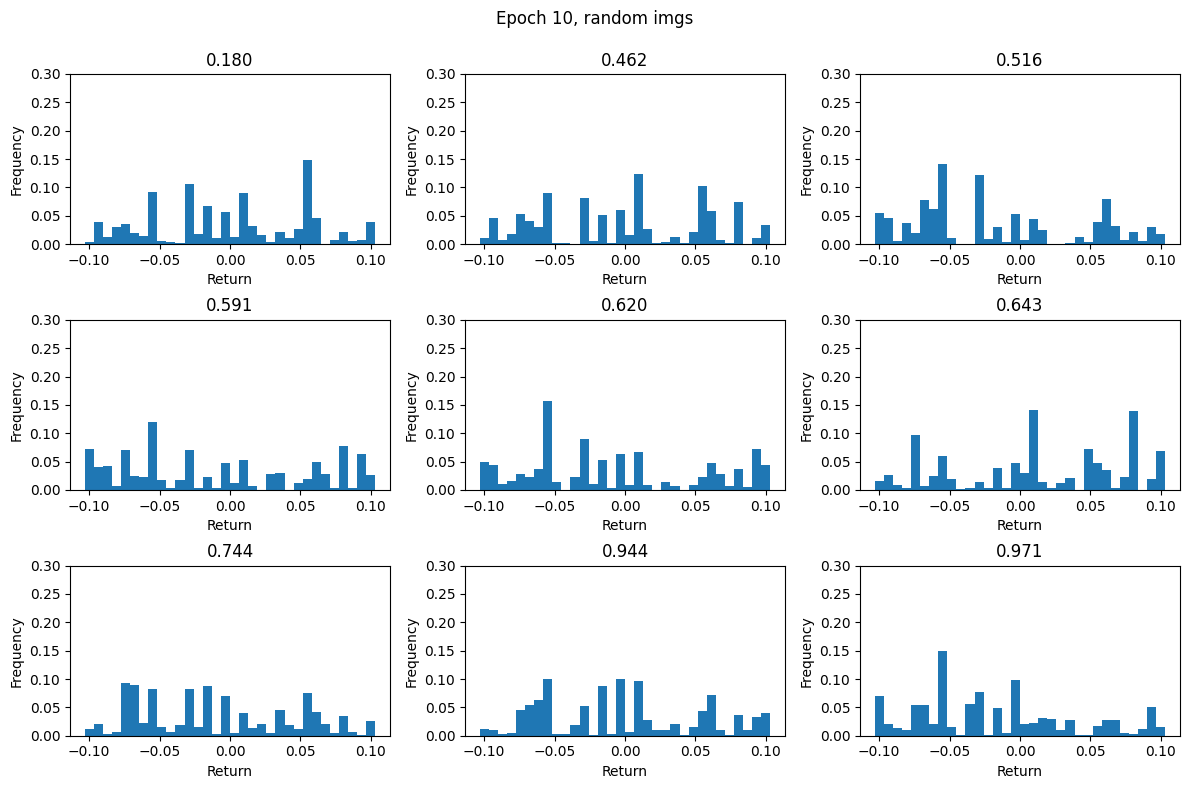

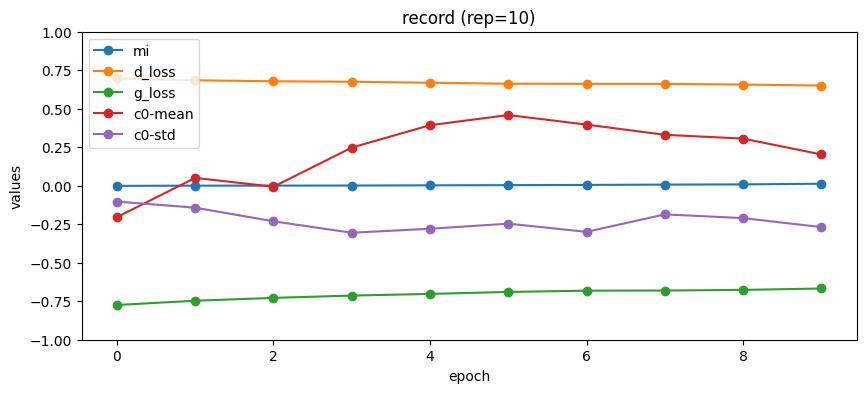

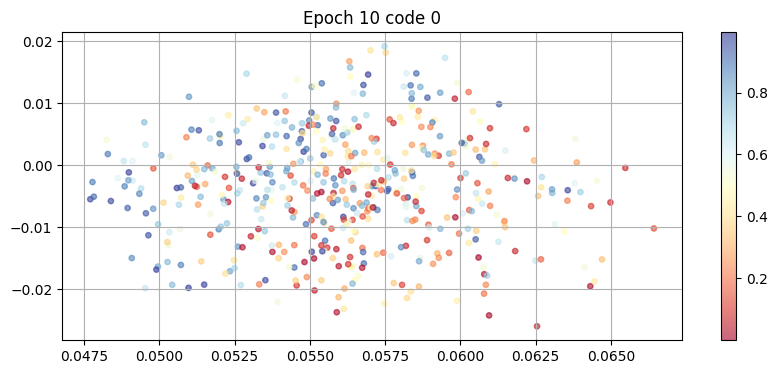

100%|██████████| 31/31 [01:25<00:00,  2.75s/it, G_loss=-.667, D_loss=0.648, MI=0.0158]


epoch: 11, D_loss: 0.6475614886130056, G_loss: -0.666717863851978, MI = 0.015760644789664977


100%|██████████| 31/31 [01:24<00:00,  2.73s/it, G_loss=-.659, D_loss=0.643, MI=0.018] 


epoch: 12, D_loss: 0.6434109191740712, G_loss: -0.6586674317236869, MI = 0.017975158749088165


100%|██████████| 31/31 [01:25<00:00,  2.75s/it, G_loss=-.658, D_loss=0.642, MI=0.0188]


epoch: 13, D_loss: 0.6419196782573577, G_loss: -0.6582194720545123, MI = 0.018769246916617115


100%|██████████| 31/31 [01:24<00:00,  2.73s/it, G_loss=-.654, D_loss=0.638, MI=0.0257]


epoch: 14, D_loss: 0.6377663977684513, G_loss: -0.6535713614956025, MI = 0.02570210204970452


100%|██████████| 31/31 [01:24<00:00,  2.74s/it, G_loss=-.652, D_loss=0.639, MI=0.0273]


epoch: 15, D_loss: 0.6385967673793915, G_loss: -0.6520184432306597, MI = 0.027276188615829713


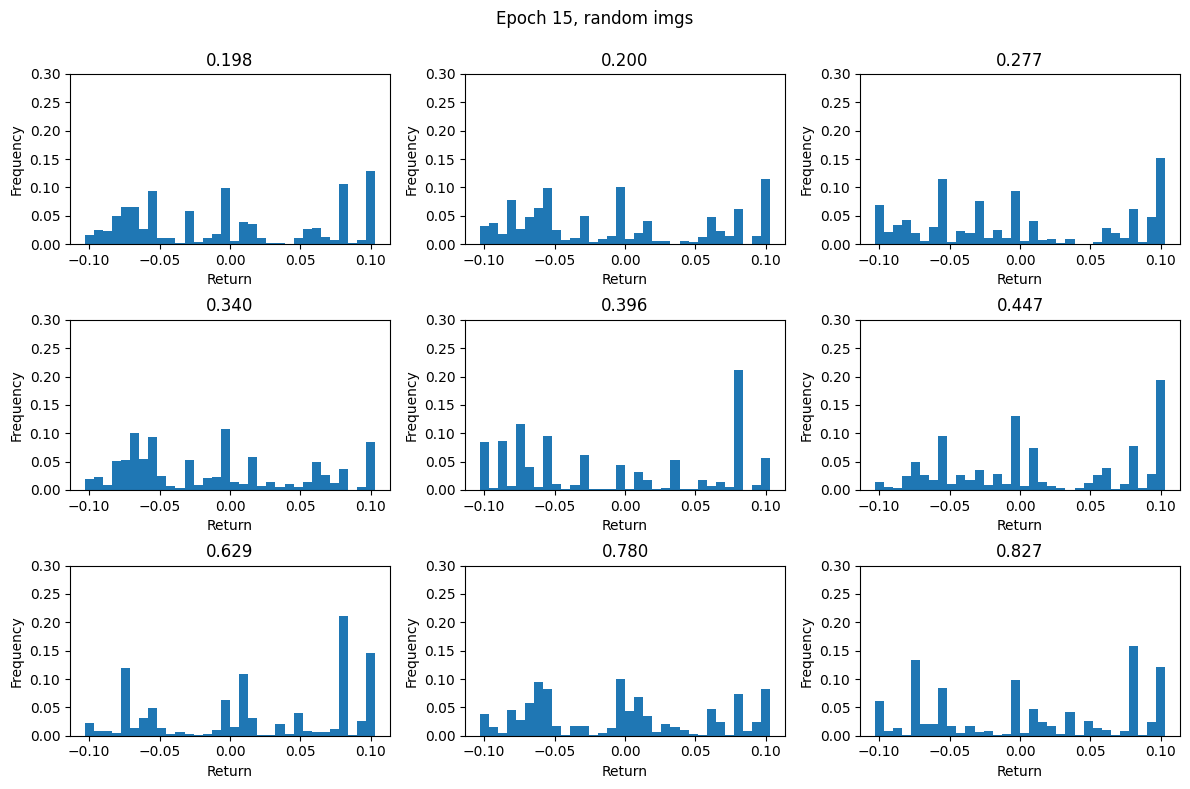

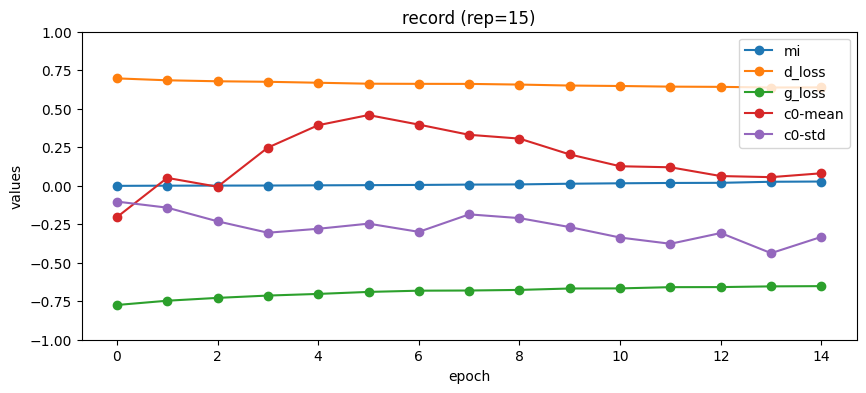

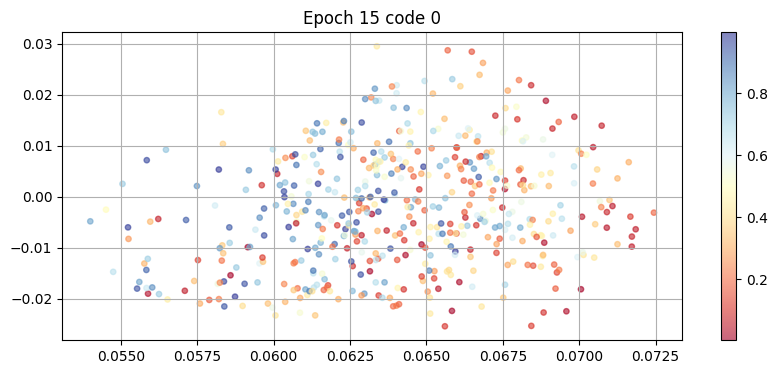

100%|██████████| 31/31 [01:24<00:00,  2.74s/it, G_loss=-.648, D_loss=0.634, MI=0.0273]


epoch: 16, D_loss: 0.6341899921817165, G_loss: -0.6481263791361163, MI = 0.027292489524810545


100%|██████████| 31/31 [01:24<00:00,  2.71s/it, G_loss=-.643, D_loss=0.625, MI=0.0351]


epoch: 17, D_loss: 0.6247775073974363, G_loss: -0.6425010446579226, MI = 0.03509245620619866


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.637, D_loss=0.626, MI=0.0433]


epoch: 18, D_loss: 0.6263673805421398, G_loss: -0.6367019511038258, MI = 0.04326837245495089


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.637, D_loss=0.626, MI=0.0462]


epoch: 19, D_loss: 0.6257894404472844, G_loss: -0.6366192544660261, MI = 0.04618779545830142


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.636, D_loss=0.619, MI=0.0519]


epoch: 20, D_loss: 0.619394060104124, G_loss: -0.6357715437489171, MI = 0.05190942652763859


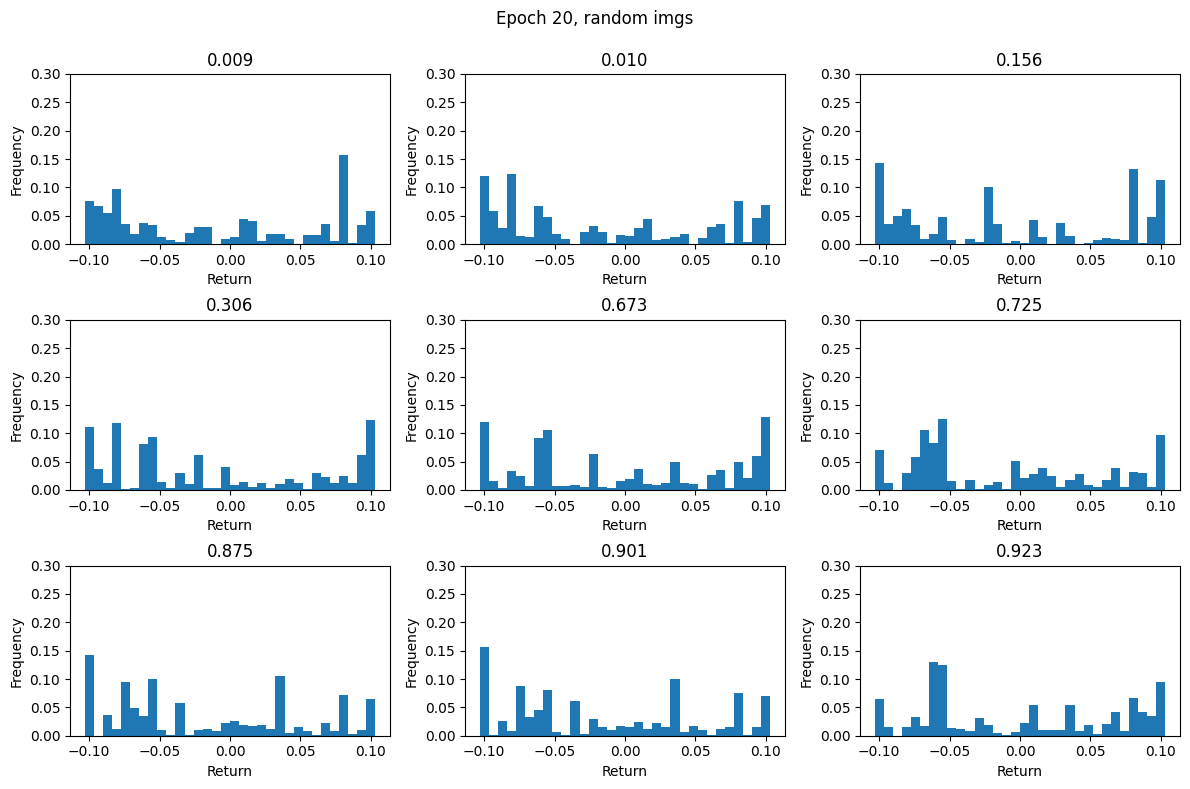

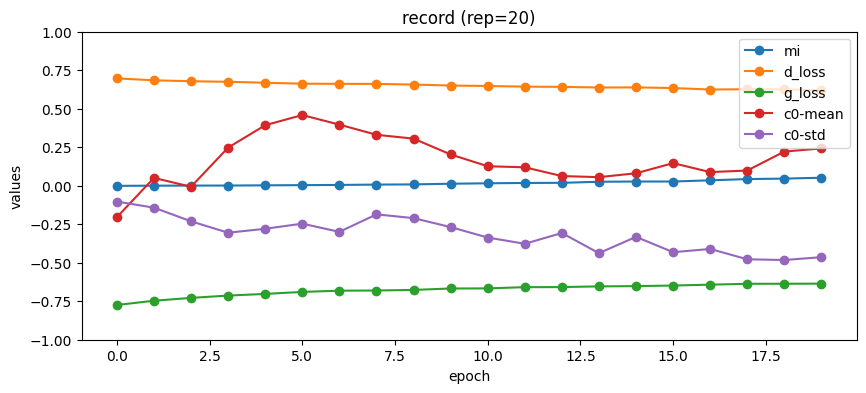

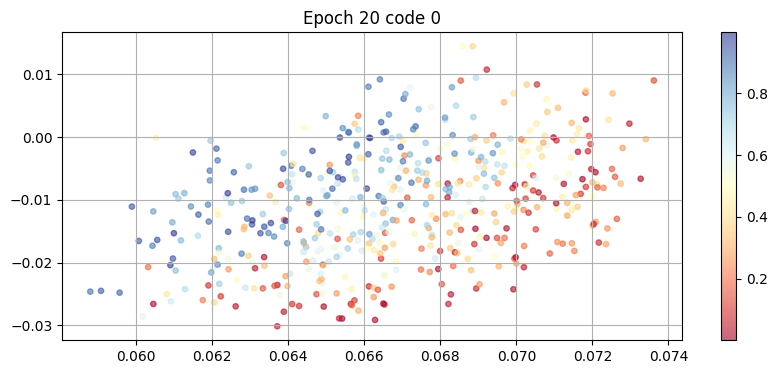

100%|██████████| 31/31 [01:21<00:00,  2.64s/it, G_loss=-.638, D_loss=0.62, MI=0.0533] 


epoch: 21, D_loss: 0.6204321730521417, G_loss: -0.6382289336573693, MI = 0.05326294081826364


100%|██████████| 31/31 [01:25<00:00,  2.76s/it, G_loss=-.639, D_loss=0.623, MI=0.0672]


epoch: 22, D_loss: 0.6226315325306307, G_loss: -0.6388258203383415, MI = 0.06721041519795695


100%|██████████| 31/31 [01:29<00:00,  2.87s/it, G_loss=-.64, D_loss=0.618, MI=0.0751] 


epoch: 23, D_loss: 0.618185902795484, G_loss: -0.6400924055807052, MI = 0.07507333820385317


100%|██████████| 31/31 [01:28<00:00,  2.86s/it, G_loss=-.636, D_loss=0.618, MI=0.0879]


epoch: 24, D_loss: 0.6183718904372184, G_loss: -0.6362237430387928, MI = 0.08788738844375457


100%|██████████| 31/31 [01:29<00:00,  2.89s/it, G_loss=-.634, D_loss=0.612, MI=0.0943]


epoch: 25, D_loss: 0.6121103032942741, G_loss: -0.6339877036310011, MI = 0.09431262807019296


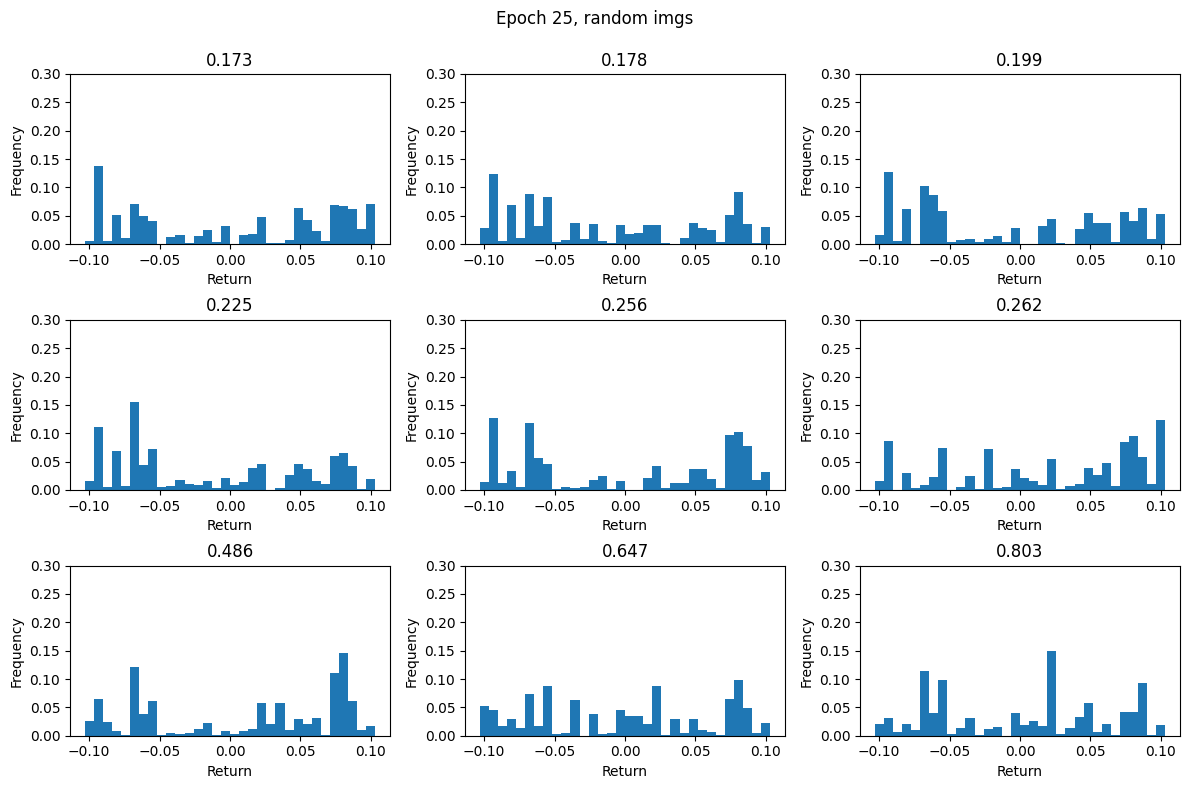

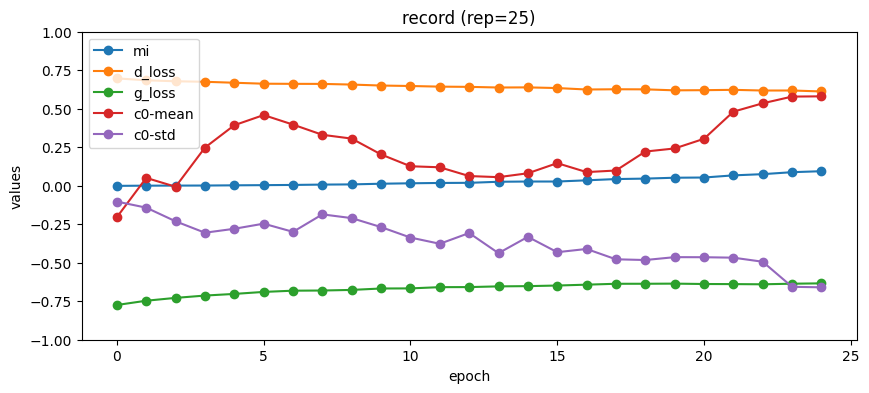

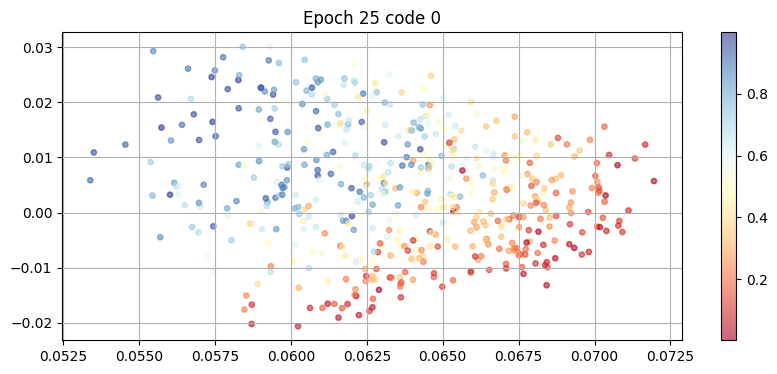

100%|██████████| 31/31 [01:34<00:00,  3.06s/it, G_loss=-.628, D_loss=0.606, MI=0.0978]


epoch: 26, D_loss: 0.6063564592792142, G_loss: -0.6278231336224463, MI = 0.09779005365506295


100%|██████████| 31/31 [01:34<00:00,  3.06s/it, G_loss=-.626, D_loss=0.604, MI=0.118] 


epoch: 27, D_loss: 0.6043320798104809, G_loss: -0.6263127826875255, MI = 0.11801113380539802


100%|██████████| 31/31 [01:32<00:00,  2.98s/it, G_loss=-.623, D_loss=0.602, MI=0.118]


epoch: 28, D_loss: 0.601562173135819, G_loss: -0.6226754092401073, MI = 0.11814954828831457


100%|██████████| 31/31 [01:29<00:00,  2.88s/it, G_loss=-.629, D_loss=0.607, MI=0.134]


epoch: 29, D_loss: 0.6069316517922186, G_loss: -0.6294740592279742, MI = 0.13387899389190058


100%|██████████| 31/31 [01:31<00:00,  2.96s/it, G_loss=-.622, D_loss=0.599, MI=0.164]


epoch: 30, D_loss: 0.5991644647813612, G_loss: -0.6220660151973847, MI = 0.16391107343858288


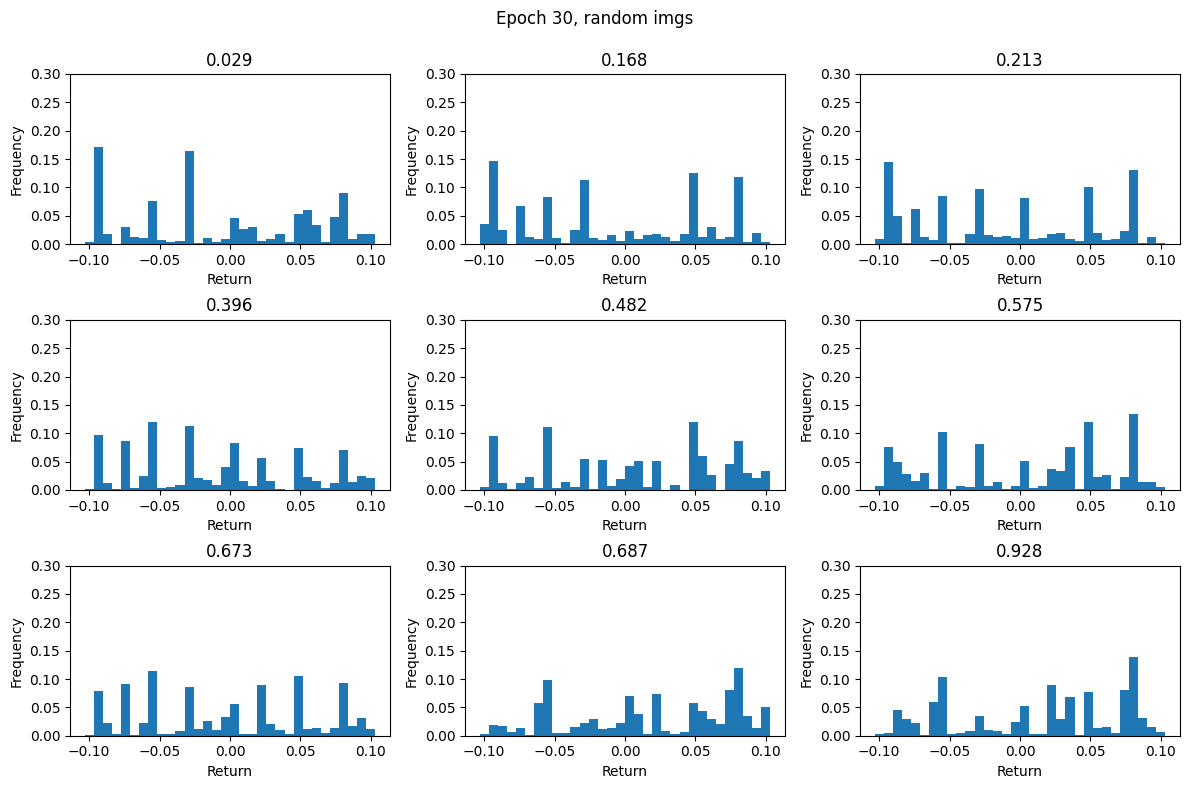

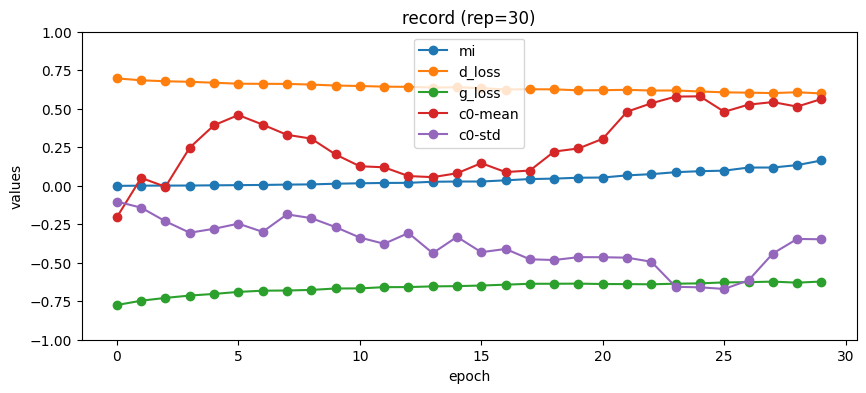

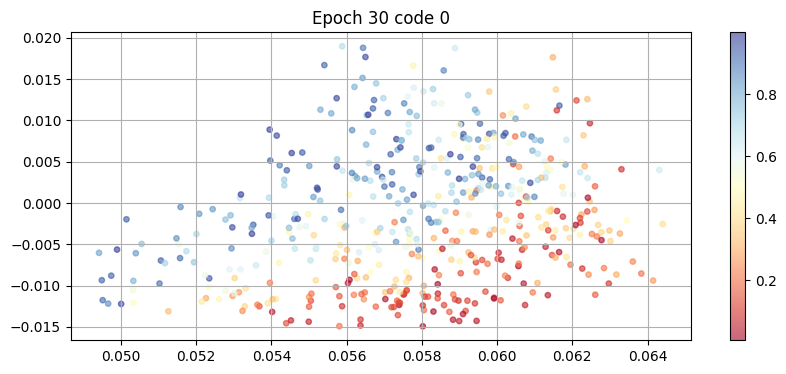

100%|██████████| 31/31 [01:30<00:00,  2.92s/it, G_loss=-.616, D_loss=0.593, MI=0.148]


epoch: 31, D_loss: 0.5929388596165565, G_loss: -0.6160977771205287, MI = 0.14801491941175154


100%|██████████| 31/31 [01:33<00:00,  3.02s/it, G_loss=-.615, D_loss=0.596, MI=0.167]


epoch: 32, D_loss: 0.5957147267556959, G_loss: -0.6145089153320559, MI = 0.16720539619845728


100%|██████████| 31/31 [01:30<00:00,  2.92s/it, G_loss=-.617, D_loss=0.587, MI=0.177]


epoch: 33, D_loss: 0.5869603945362952, G_loss: -0.6169113574489471, MI = 0.17734891416565066


100%|██████████| 31/31 [01:31<00:00,  2.95s/it, G_loss=-.616, D_loss=0.586, MI=0.194]


epoch: 34, D_loss: 0.5856454526224444, G_loss: -0.6161601831836085, MI = 0.1935650333762169


100%|██████████| 31/31 [01:29<00:00,  2.89s/it, G_loss=-.614, D_loss=0.58, MI=0.209] 


epoch: 35, D_loss: 0.5798477568934041, G_loss: -0.6141803764527843, MI = 0.20926529409423952


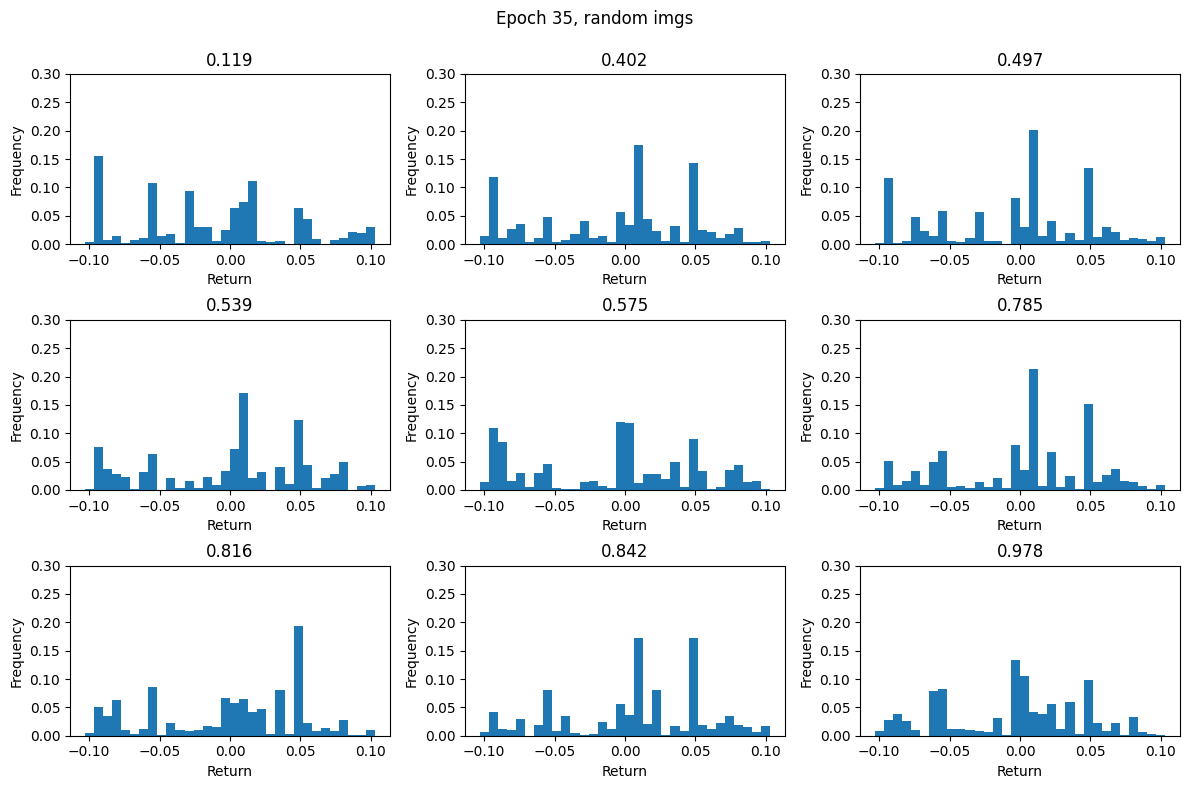

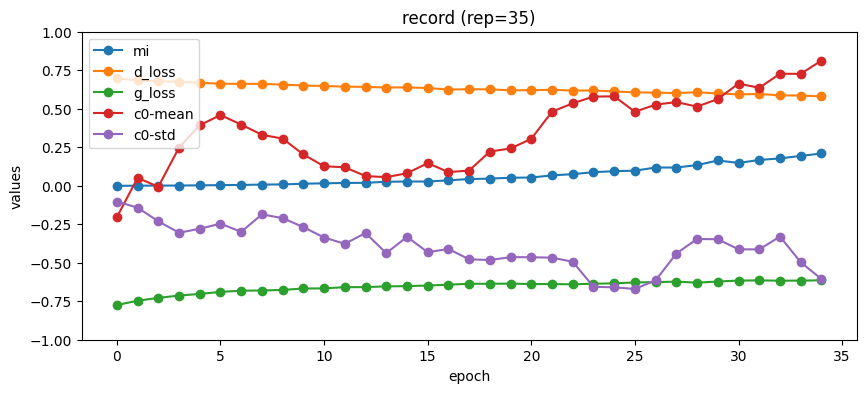

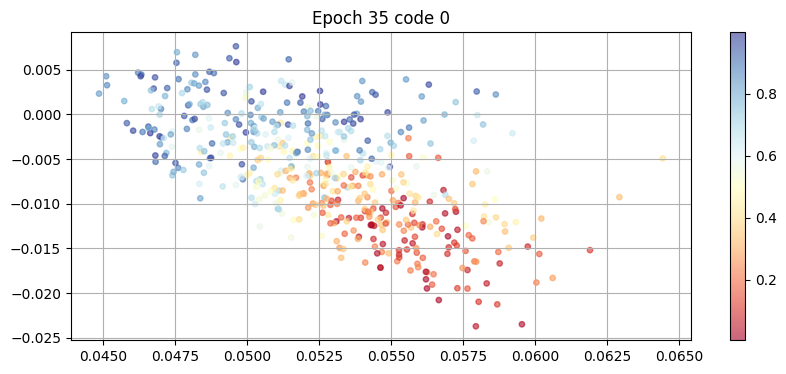

100%|██████████| 31/31 [01:29<00:00,  2.89s/it, G_loss=-.61, D_loss=0.581, MI=0.228] 


epoch: 36, D_loss: 0.5808515221841873, G_loss: -0.6095586688287796, MI = 0.22827214002609253


100%|██████████| 31/31 [01:30<00:00,  2.93s/it, G_loss=-.616, D_loss=0.585, MI=0.24] 


epoch: 37, D_loss: 0.5850723558856595, G_loss: -0.6161740153066574, MI = 0.23970649319310341


100%|██████████| 31/31 [01:30<00:00,  2.92s/it, G_loss=-.615, D_loss=0.573, MI=0.283]


epoch: 38, D_loss: 0.5733769862882553, G_loss: -0.6149230503266857, MI = 0.28320035819084416


100%|██████████| 31/31 [01:28<00:00,  2.86s/it, G_loss=-.608, D_loss=0.569, MI=0.268]


epoch: 39, D_loss: 0.5686040770622992, G_loss: -0.6078029774850414, MI = 0.26772070411712895


100%|██████████| 31/31 [01:32<00:00,  2.98s/it, G_loss=-.609, D_loss=0.574, MI=0.296]


epoch: 40, D_loss: 0.5744146223991148, G_loss: -0.608507094844695, MI = 0.2958654198915728


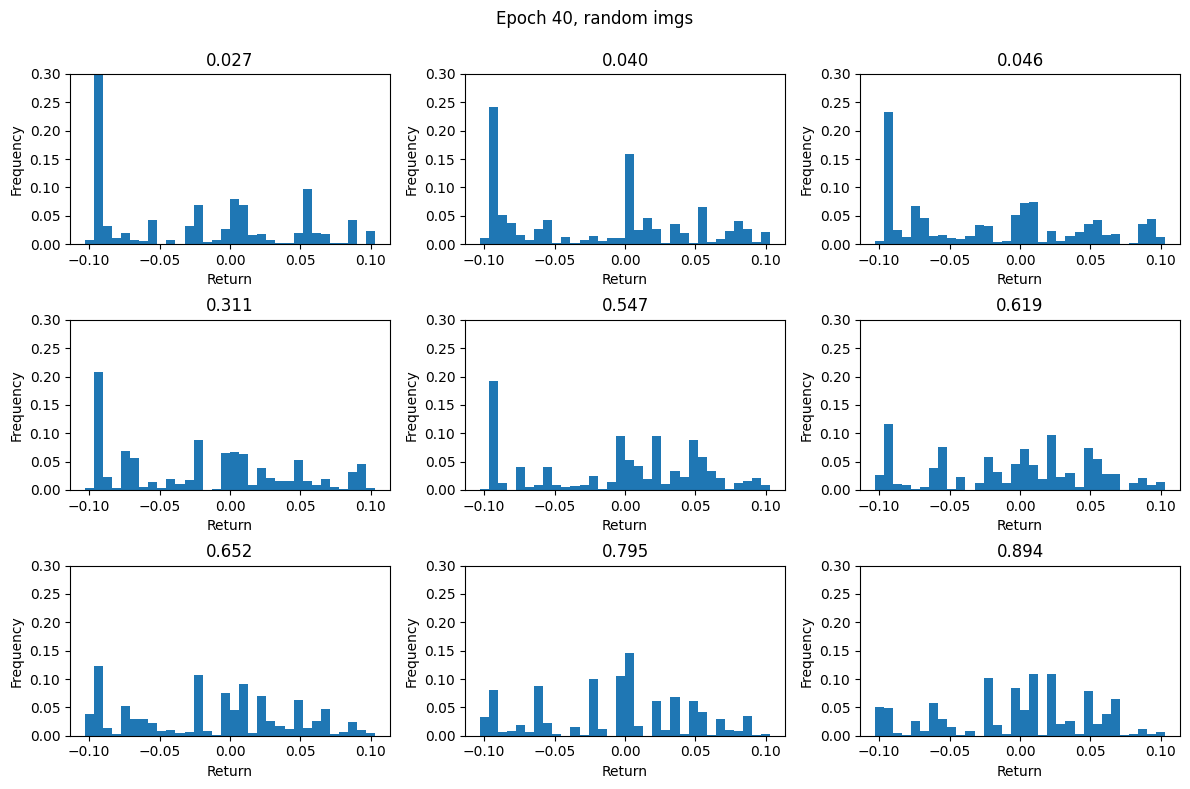

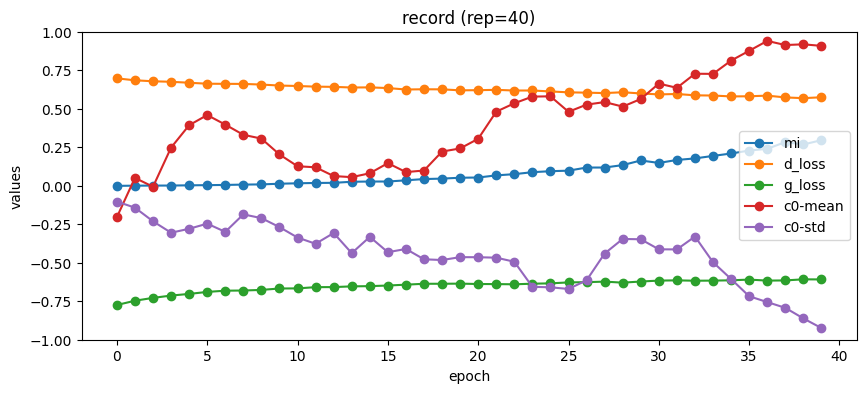

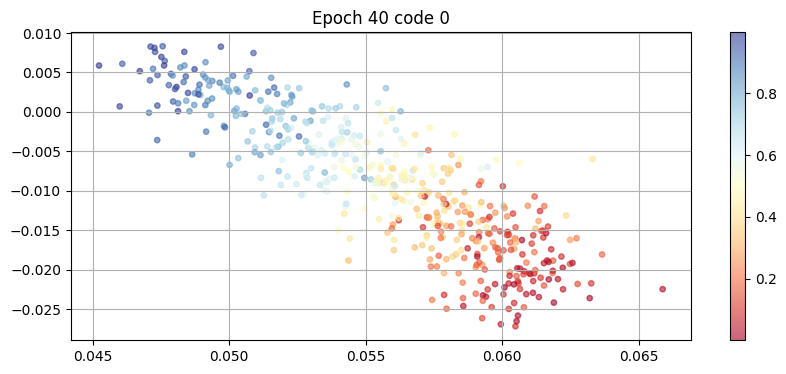

100%|██████████| 31/31 [01:27<00:00,  2.83s/it, G_loss=-.602, D_loss=0.57, MI=0.303] 


epoch: 41, D_loss: 0.5704497291195777, G_loss: -0.6024175132474592, MI = 0.3028329899234156


100%|██████████| 31/31 [01:28<00:00,  2.87s/it, G_loss=-.605, D_loss=0.564, MI=0.357]


epoch: 42, D_loss: 0.5635430370607684, G_loss: -0.6049286992319168, MI = 0.3571612964714727


100%|██████████| 31/31 [01:27<00:00,  2.84s/it, G_loss=-.61, D_loss=0.567, MI=0.383] 


epoch: 43, D_loss: 0.5673774269319349, G_loss: -0.6101014806378272, MI = 0.38276118184289626


100%|██████████| 31/31 [01:28<00:00,  2.85s/it, G_loss=-.6, D_loss=0.56, MI=0.382]   


epoch: 44, D_loss: 0.5595690319615025, G_loss: -0.600489568325781, MI = 0.38199300294922245


100%|██████████| 31/31 [01:29<00:00,  2.88s/it, G_loss=-.607, D_loss=0.554, MI=0.417]


epoch: 45, D_loss: 0.5539568201188119, G_loss: -0.6066367837690538, MI = 0.4168068853116805


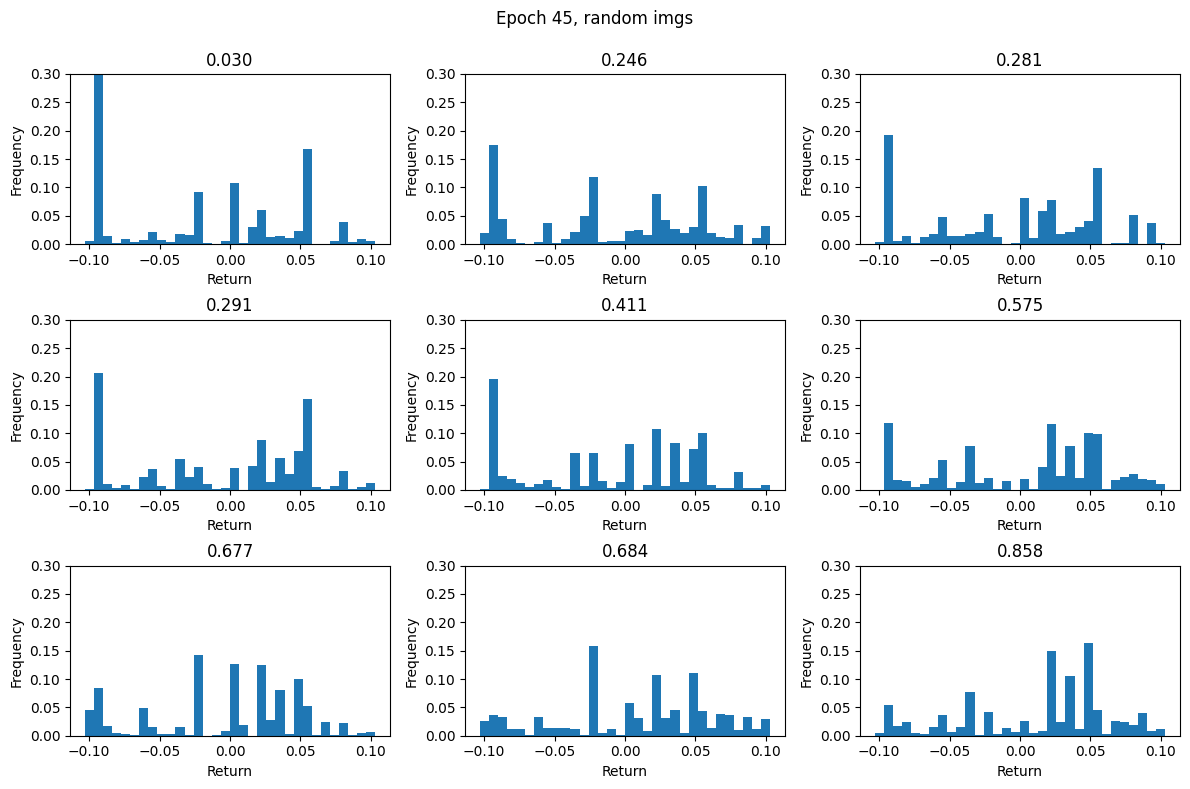

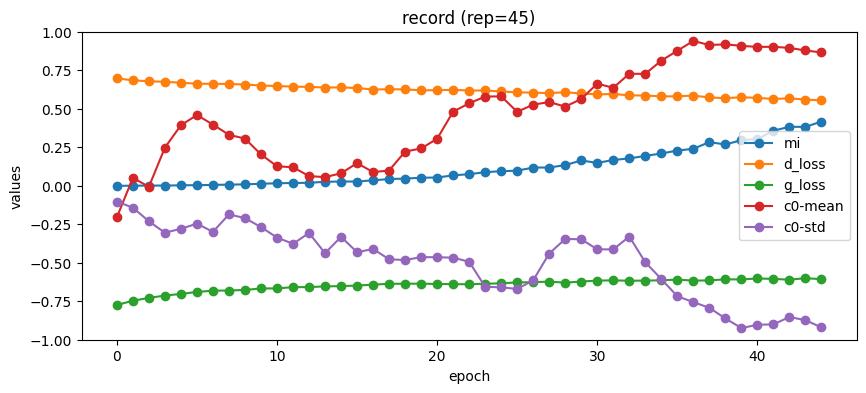

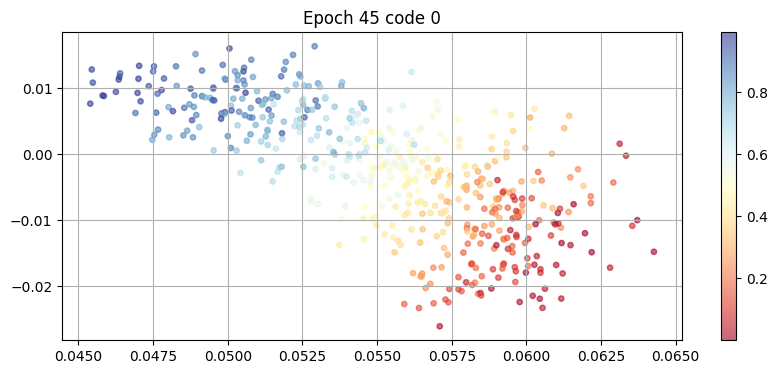

100%|██████████| 31/31 [01:29<00:00,  2.87s/it, G_loss=-.603, D_loss=0.549, MI=0.4]  


epoch: 46, D_loss: 0.5494826762906967, G_loss: -0.60347754340018, MI = 0.40049446975031205


100%|██████████| 31/31 [01:28<00:00,  2.86s/it, G_loss=-.589, D_loss=0.551, MI=0.441]


epoch: 47, D_loss: 0.5513644410717872, G_loss: -0.5890969826329139, MI = 0.44135555624961853


100%|██████████| 31/31 [01:27<00:00,  2.84s/it, G_loss=-.595, D_loss=0.553, MI=0.417]


epoch: 48, D_loss: 0.5527476322266364, G_loss: -0.5954689268142946, MI = 0.41674247047593516


100%|██████████| 31/31 [01:28<00:00,  2.84s/it, G_loss=-.594, D_loss=0.533, MI=0.43] 


epoch: 49, D_loss: 0.5328060974997859, G_loss: -0.5942351029765222, MI = 0.4298997559855061


100%|██████████| 31/31 [01:29<00:00,  2.87s/it, G_loss=-.594, D_loss=0.54, MI=0.45]  


epoch: 50, D_loss: 0.5402915468139033, G_loss: -0.5940212357428766, MI = 0.4504643044164104


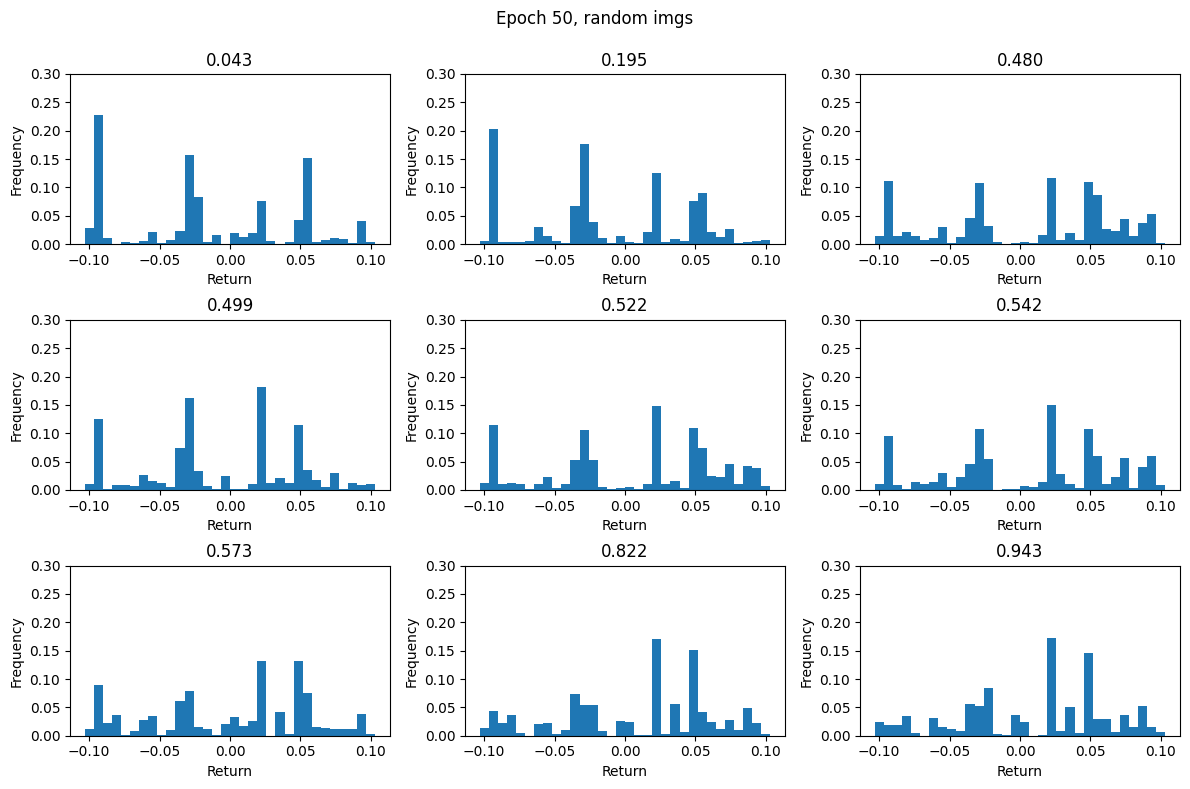

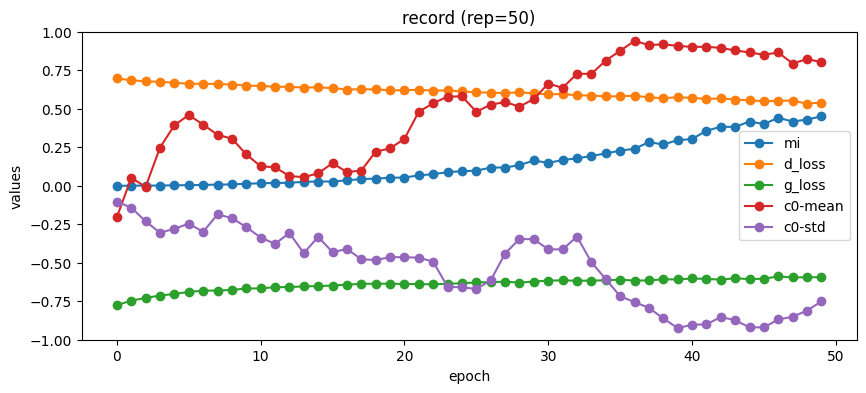

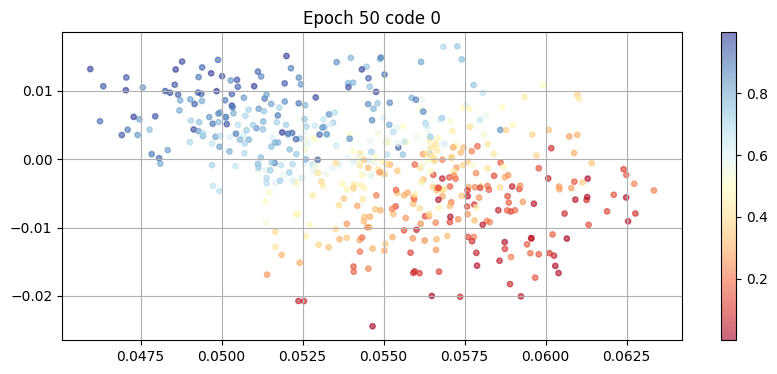

100%|██████████| 31/31 [01:27<00:00,  2.83s/it, G_loss=-.595, D_loss=0.548, MI=0.429]


epoch: 51, D_loss: 0.5479047279204091, G_loss: -0.5950375814591685, MI = 0.42941982082782254


100%|██████████| 31/31 [01:28<00:00,  2.86s/it, G_loss=-.591, D_loss=0.546, MI=0.456]


epoch: 52, D_loss: 0.5464629386701891, G_loss: -0.5907826481326934, MI = 0.45561051560986426


100%|██████████| 31/31 [01:29<00:00,  2.88s/it, G_loss=-.584, D_loss=0.53, MI=0.456] 


epoch: 53, D_loss: 0.5304532656746526, G_loss: -0.5839373603943856, MI = 0.4556575177177306


100%|██████████| 31/31 [01:28<00:00,  2.85s/it, G_loss=-.582, D_loss=0.52, MI=0.476] 


epoch: 54, D_loss: 0.5201768980872247, G_loss: -0.5822998496793932, MI = 0.4757182069363133


100%|██████████| 31/31 [01:33<00:00,  3.02s/it, G_loss=-.585, D_loss=0.529, MI=0.498]


epoch: 55, D_loss: 0.5293837016628634, G_loss: -0.5851863584210796, MI = 0.4978845994318685


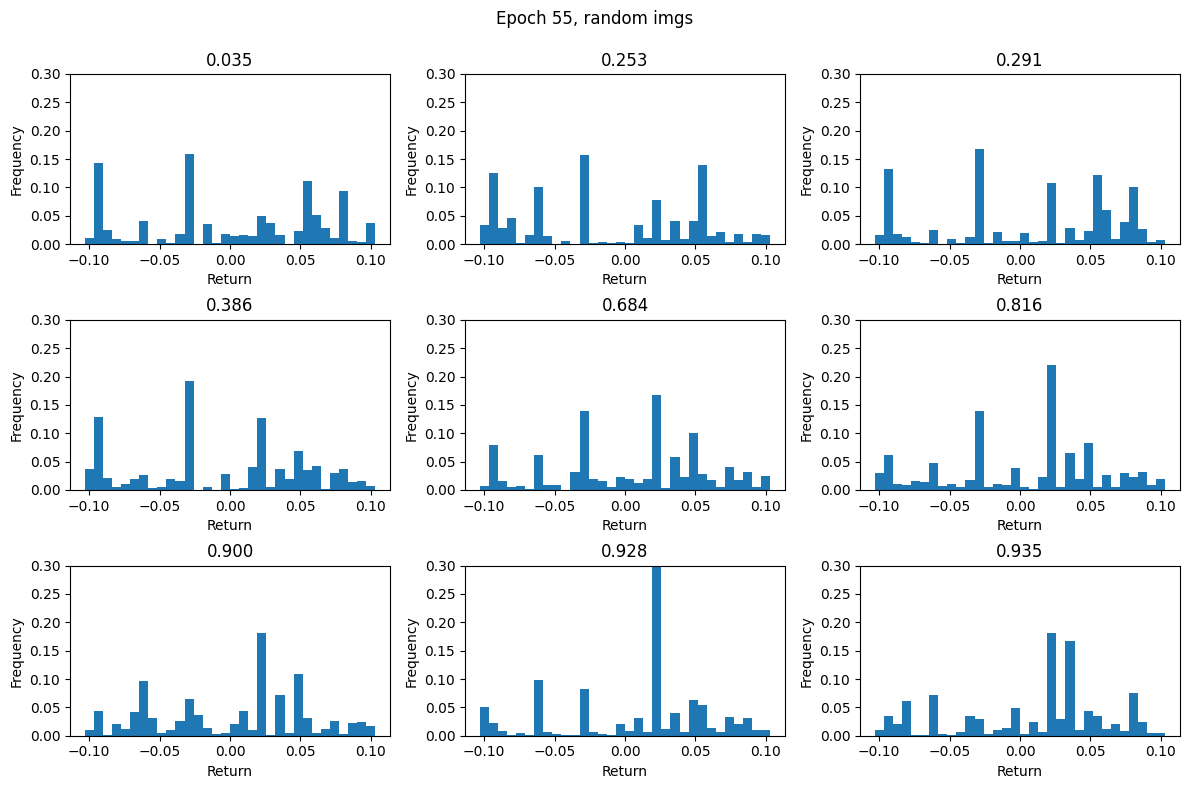

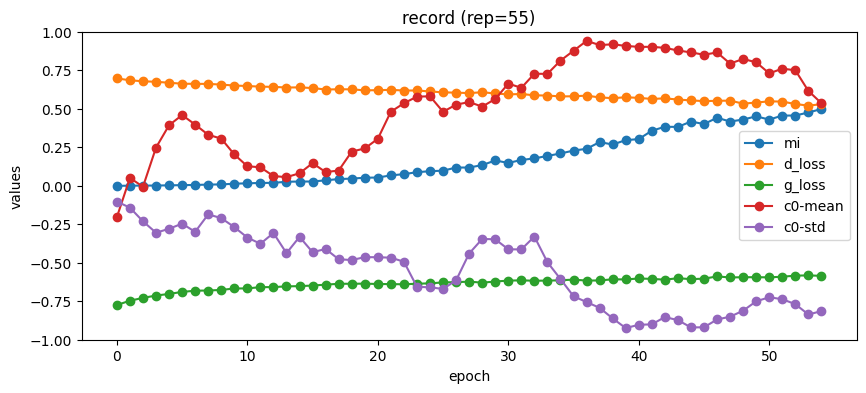

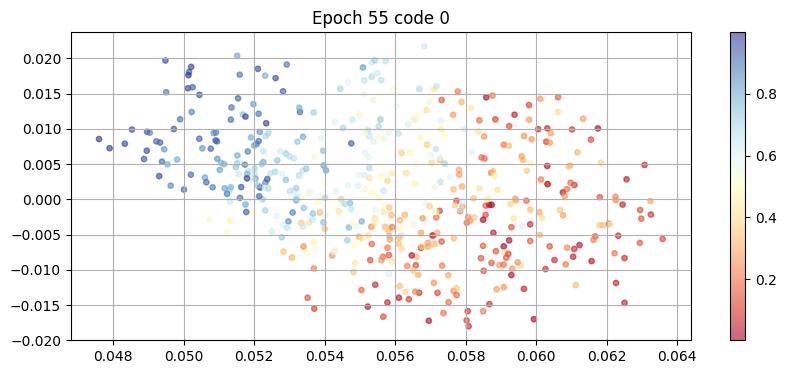

100%|██████████| 31/31 [01:41<00:00,  3.26s/it, G_loss=-.581, D_loss=0.521, MI=0.511]


epoch: 56, D_loss: 0.5214209787307247, G_loss: -0.5805185033429053, MI = 0.5108486192841684


100%|██████████| 31/31 [01:40<00:00,  3.24s/it, G_loss=-.581, D_loss=0.525, MI=0.591]


epoch: 57, D_loss: 0.5252433092363419, G_loss: -0.581311950760503, MI = 0.591442673437057


100%|██████████| 31/31 [01:42<00:00,  3.32s/it, G_loss=-.571, D_loss=0.522, MI=0.501]


epoch: 58, D_loss: 0.5221219610783362, G_loss: -0.5705190050986505, MI = 0.501389745743044


100%|██████████| 31/31 [01:41<00:00,  3.28s/it, G_loss=-.58, D_loss=0.521, MI=0.578] 


epoch: 59, D_loss: 0.520797694883039, G_loss: -0.5795340672616036, MI = 0.5776746580677647


100%|██████████| 31/31 [01:42<00:00,  3.31s/it, G_loss=-.572, D_loss=0.511, MI=0.506]


epoch: 60, D_loss: 0.5108524916633483, G_loss: -0.572142977868357, MI = 0.5063599674932419


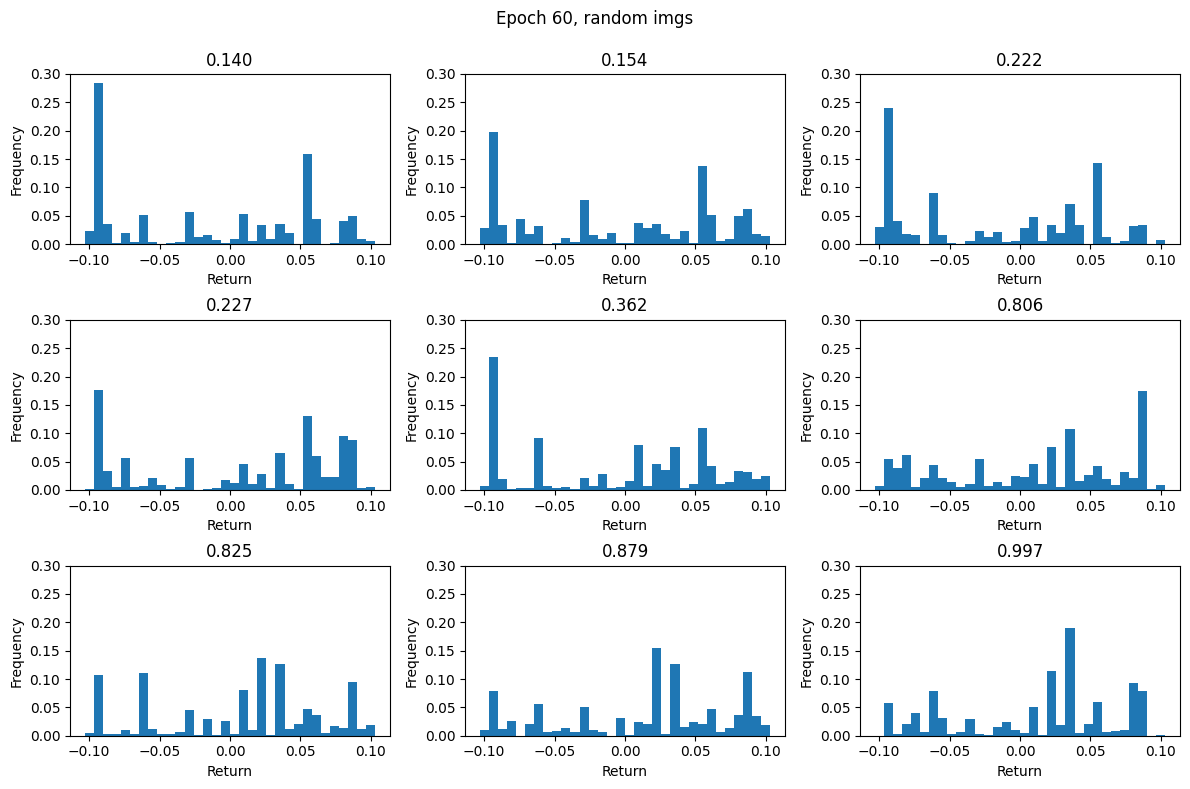

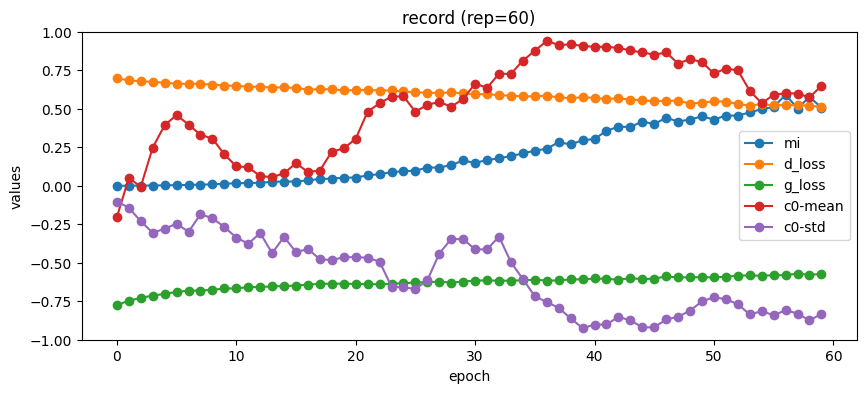

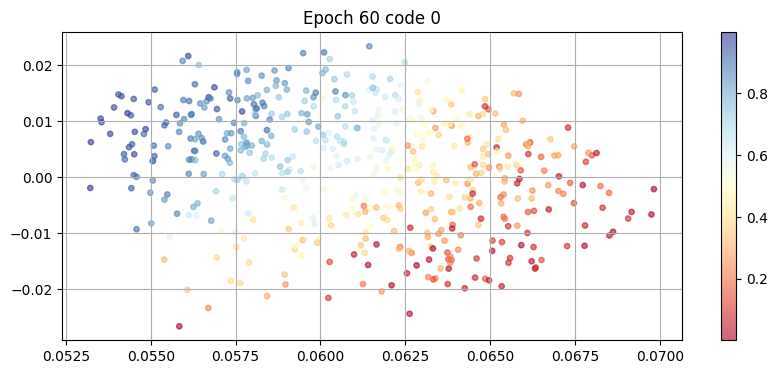

100%|██████████| 31/31 [01:40<00:00,  3.23s/it, G_loss=-.574, D_loss=0.507, MI=0.549]


epoch: 61, D_loss: 0.5067167099445097, G_loss: -0.5735234522050426, MI = 0.548777473549689


100%|██████████| 31/31 [01:41<00:00,  3.26s/it, G_loss=-.563, D_loss=0.522, MI=0.533]


epoch: 62, D_loss: 0.5215328633785248, G_loss: -0.5626735706483165, MI = 0.5334999445945986


100%|██████████| 31/31 [01:38<00:00,  3.18s/it, G_loss=-.566, D_loss=0.505, MI=0.537]


epoch: 63, D_loss: 0.5046783743366119, G_loss: -0.5662519181928327, MI = 0.5373443009391907


100%|██████████| 31/31 [01:40<00:00,  3.24s/it, G_loss=-.564, D_loss=0.506, MI=0.552]


epoch: 64, D_loss: 0.5058001077944233, G_loss: -0.5638335731721693, MI = 0.5517639287056462


 10%|▉         | 3/31 [00:09<01:27,  3.13s/it, G_loss=-.556, D_loss=0.477, MI=0.787]

In [391]:
import openpyxl
epoch = 1500

recorder_keywords = ['d_loss', 'g_loss', 'mi']
for i in range(code_qubits):
    recorder_keywords.append(f'c{i}-mean')
    recorder_keywords.append(f'c{i}-std')
recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(dataset)
    iter_num = int(len(dataset) * 0.25 //BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.

    G_loss_sum = 0.0
    D_loss_sum = 0.0
    mi_sum = 0.0

    log_gen_outputs = []
    log_gen_codes = []
    pbar = tqdm(range(iter_num))

    for i in pbar:
        batch = torch.FloatTensor(dataset[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])

        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits))
        generator_output, generator_loss = generator_train_step(generator_params, generator_seed, use_mine=use_mine)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()

        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    G_scheduler.step()
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)

    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    
    log_gen_outputs = np.concatenate(log_gen_outputs, axis=0)
    log_gen_codes = np.concatenate(log_gen_codes, axis=0)
    
    mean_corrs, std_corrs, means, stds = calculate_corr(log_gen_outputs, log_gen_codes)
    for i in range(code_qubits):
        recorder[f'c{i}-mean'].append(mean_corrs[i])
        recorder[f'c{i}-std'].append(std_corrs[i])

    visualize_output(log_gen_outputs, log_gen_codes, means, stds, title, rep, recorder)

    with open(f'result/{title}/discriminator_{rep}.pkl', 'wb') as file:
        pickle.dump(discriminator, file)
    with open(f'result/{title}/generator_{rep}.pkl', 'wb') as file:
        pickle.dump(generator_params, file)

    df = pd.DataFrame(recorder)
    output_filename = f'result/{title}/recorder.xlsx'
    df.to_excel(output_filename, index=False)

    final_rep = rep

## 모든 지표 엑셀파일로 저장

In [ ]:
import openpyxl
df = pd.DataFrame(recorder)
output_filename = f'result/{title}/recorder.xlsx'
df.to_excel(output_filesname, index=False)

## 최종 결과 plot

In [ ]:
inputs = []
outputs = []

for i in tqdm(range(5000)):
    with torch.no_grad():
        z = np.random.uniform(-1, 1, (1, n_qubits, 1))
        code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
        generator_output = generator_forward(generator_params, z, copula=output_copula)
        generator_output = generator_output.cpu().numpy().reshape(2)
        outputs.append(generator_output)
        inputs.append(code_input)

inputs = np.array(inputs).reshape(-1, code_qubits)

for code_ind in range(code_qubits):
    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.2)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'code{code_ind}-distribution (rep = {final_rep})')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()